# Build KNN Classifier Models

## Import Processed Data

In [5]:
import pandas as pd
import os
import numpy as np
import pickle
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [6]:
# set path of the processed data
processed_data_path = os.path.join(os.path.pardir, 'data', 'processed')
train_processed_file_path = os.path.join(processed_data_path, 'train_processed.csv')
test_processed_file_path = os.path.join(processed_data_path, 'test_processed.csv')
unlabeled_processed_file_path = os.path.join(processed_data_path, 'unlabeled_processed.csv')

# create data frames for train, test, and unlabled data
train_df = pd.read_csv(train_processed_file_path, index_col = 'ImageId')
test_df = pd.read_csv(test_processed_file_path, index_col = 'ImageId')
unlabeled_df = pd.read_csv(unlabeled_processed_file_path, index_col = 'ImageId')

In [7]:
# in the train and test data, X contains all the columns except 'label'
# y is 'label'
X_train = train_df.drop(['label'], axis = 1)
y_train = train_df['label']
X_test = test_df.drop(['label'], axis = 1)
y_test = test_df['label']

## PCA

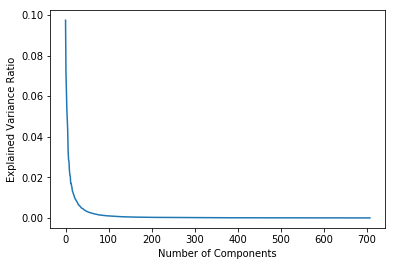

In [8]:
# let's look at how explained variance ratio varies with number of components
import matplotlib.pyplot as plt
%matplotlib inline

pca = PCA()
pca.fit(X_train)

plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [9]:
# it looks like we can get away with using about 50 components
pca = PCA(n_components = 50).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
unlabeled_pca = pca.transform(unlabeled_df)

## Default KNN Classifier (with PCA)

In [10]:
# use 5-fold CV to evaluate accuracy with pca-train data
model = KNeighborsClassifier()
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)
print(scores.mean(), '\n')

print("CV Accuracy: %0.2f +/- %0.2f" % (scores.mean(), 2 * scores.std()), '\n')
print(scores)

0.9705954098325786 

CV Accuracy: 0.97 +/- 0.00 

[0.96862454 0.97381342 0.96859652 0.97171777 0.9702248 ]


## Tuned KNN Classifier (with PCA)

In [20]:
#
#  SKIP THIS: TAKES TOO LONG ON MY LAPTOP
#
# define the parameter values that will be considered
num_of_neighbors = [3, 4, 5, 6, 7,]
weights = ['uniform', 'distance']
params = {'n_neighbors' : num_of_neighbors,
          'weights' : weights}

# used to evaluate all possible combinations with 5-fold cross-validation
grid_search = GridSearchCV(KNeighborsClassifier(),
                           param_grid = params,
                           cv = 5,
                           refit = True,
                           return_train_score = True)

# fit
grid_search.fit(X_train_pca, y_train)

# return the optimal combo of parameters and its score
print(grid_search.best_params_, '\n')
print(grid_search.best_score_)

Because a decent grid search takes so much time on my laptop, I just set the hyperparameter values myself and recorded the CV scores. Here is the best combination I could find:

In [11]:
# use 5-fold CV to evaluate accuracy with pca-train data
model = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
scores = cross_val_score(model, X_train_pca, y_train, cv = 5)
print(scores.mean(), '\n')

print("CV Accuracy: %0.2f +/- %0.2f" % (scores.mean(), 2 * scores.std()), '\n')
print(scores)

0.9736905377736939 

CV Accuracy: 0.97 +/- 0.00 

[0.97189591 0.97812825 0.97082899 0.97395058 0.97364895]


## Kaggle Score: 0.97385

Before we "go live" with this model (i.e., submit its predictions to Kaggle), let's check how it performs on the test data, data that it has never seen and had no influence on its selection:

In [12]:
# fit model to entire train set
model = KNeighborsClassifier(n_neighbors = 4,
                             weights = 'distance').fit(X_train_pca, y_train)

# evaluate accuracy on test set
print('Tuned KNN (w/PCA) Accuracy: ' + '{0:2f}'.format(model.score(X_test_pca, y_test)))

Tuned KNN (w/PCA) Accuracy: 0.974405


Looks good, make the submission to Kaggle.

In [13]:
# generate predictions
predictions = model.predict(unlabeled_pca)

# create a new data frame with two columns: ImageId and our predicted values for 'label'
submission_df = pd.DataFrame({'ImageId' : unlabeled_df.index, 'label' : predictions})

# write submission to disk...
# first define paths
submission_data_path = os.path.join(os.path.pardir, 'data', 'external')
submission_file_path = os.path.join(submission_data_path, 'knn_with_pca.csv')

# create the .csv file
# index is False since we don't want a third column
submission_df.to_csv(submission_file_path, index = False)

## Model Persistence

In [14]:
# create file paths
pca_file_path = os.path.join(os.path.pardir, 'models', 'pca_50.pkl')
model_file_path = os.path.join(os.path.pardir, 'models', 'knn_model.pkl')

In [15]:
# open files to write (in binary format)
pca_file_pickle = open(pca_file_path, 'wb')
model_file_pickle = open(model_file_path, 'wb')

In [16]:
# persist the model and pca
pickle.dump(pca, pca_file_pickle)
pickle.dump(model, model_file_pickle)

In [17]:
# close the files
pca_file_pickle.close()
model_file_pickle.close()

## Optional: Check the persisted model

In [19]:
# create file paths
pca_file_path = os.path.join(os.path.pardir, 'models', 'pca_50.pkl')
model_file_path = os.path.join(os.path.pardir, 'models', 'knn_model.pkl')

# open files in read mode
pca_file_pickle = open(pca_file_path, 'rb')
model_file_pickle = open(model_file_path, 'rb')

# load files
pca_loaded = pickle.load(pca_file_pickle)
model_loaded = pickle.load(model_file_pickle)

# close files
pca_file_pickle.close()
model_file_pickle.close()

In [21]:
# print the model object description
model_loaded

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [22]:
# print the pca object description
pca_loaded

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
# transform the test data using loaded pca object
X_test_pca = pca_loaded.transform(X_test)

# calculate the score using the loaded model object
# we should get 0.974405, as above
print('Persisted KNN (w/PCA) Accuracy: ' + '{0:2f}'.format(model_loaded.score(X_test_pca, y_test)))

Persisted KNN (w/PCA) Accuracy: 0.974405
